In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from src.utility import *
from src.rolling_data import RollingData
from src.per_game_model import PerGameModel
from src.init_DFs.per_game import PerGameInit
from src.init_DFs.next_game import NextGameInit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

pgModel = PerGameModel()
initPG = PerGameInit()
initNextGame = NextGameInit()

# configure

In [3]:
season = "all"
situation = "5on5"
TARGET = 'next_profit'

include_null_targets = False
null_target_value = 0

df = pd.read_csv(CSV_DB_PATH + f"{season}/PER_GAME_BY_TEAM_{situation}_{season}.csv")
df = pgModel.add_profit_target(df, include_null_targets)    
df['game_date'] = pd.to_datetime(df['game_date'])
    
selected_cols = df.columns[~df.columns.isin(IGNORED_COLS)]

#df_roll_2 = pd.read_csv(CSV_DB_PATH + f"{season}/ROLLING_2_{situation}_{season}.csv")
#df_2 = pd.merge(df, df_roll_2)

df_roll_4 = pd.read_csv(CSV_DB_PATH + f"{season}/ROLLING_4_{situation}_{season}.csv")
df_4 = pd.merge(df, df_roll_4)

#df_roll_8 = pd.read_csv(CSV_DB_PATH + f"{season}/ROLLING_8_{situation}_{season}.csv")
#df_8 = pd.merge(df, df_roll_8)

#df_roll_16 = pd.read_csv(CSV_DB_PATH + f"{season}/ROLLING_16_{situation}_{season}.csv")
#df_16 = pd.merge(df, df_roll_16)

#df_roll_32 = pd.read_csv(CSV_DB_PATH + f"{season}/ROLLING_32_{situation}_{season}.csv")
#df_32 = pd.merge(df, df_roll_32)

df_orig = df.copy()

#df = pd.merge(pd.merge(df_2.copy(), df_4.copy()), df_8.copy())
df = df_4.copy()


df["next_is_home"] = pgModel.add_col(df.copy(), "is_home")
df["next_opp_team"] = pgModel.add_col(df.copy(), "opp_team")
df["next_game_date"] = pgModel.add_col(df.copy(), "game_date")
df["next_odds"] = pgModel.add_col(df.copy(), "odds")
df["opp_odds"] = pgModel.add_col(df.copy(), "opp_odds")
df["ot_odds"] = pgModel.add_col(df.copy(), "ot_odds")
df = reorder_col(df, TARGET, 5)
df = df.set_index('game_date')

# train / test split

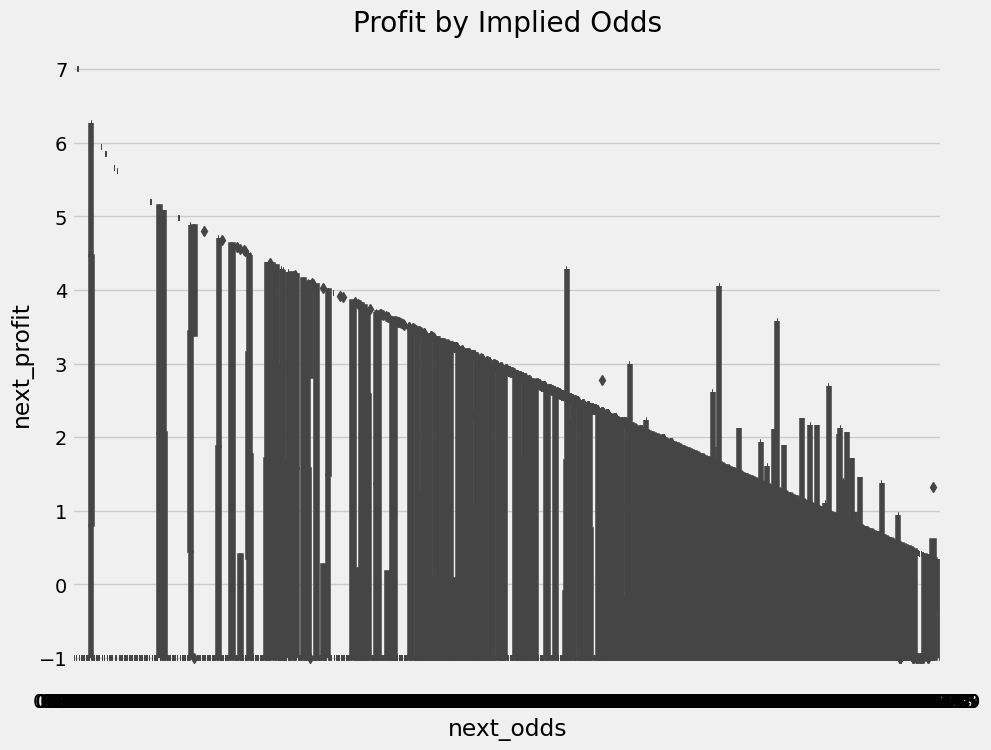

In [4]:
train = df.loc[df.index < '2022-12-31']
test = df.loc[df.index >= '2022-12-31']

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='next_odds', y=TARGET)
ax.set_title('Profit by Implied Odds')
#plt.show()

# CREATE MODEL

In [5]:
FEATURES = ['next_odds', 'next_is_home', 'xGoalsPercentage', 'corsiPercentage', 'fenwickPercentage', 
            'xGoals', 'highDangerxGoals', 'lowDangerGoals', 'totalShotCredit',
            'opp_xGoals', 'opp_highDangerxGoals', 'opp_lowDangerGoals', 'opp_totalShotCredit']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

#X_train
#y_train
#X_test
#y_test

In [6]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[05:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.37091	validation_1-rmse:1.41043
[100]	validation_0-rmse:1.26380	validation_1-rmse:1.30709
[200]	validation_0-rmse:1.24642	validation_1-rmse:1.29453
[249]	validation_0-rmse:1.24380	validation_1-rmse:1.29532


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# feature importance

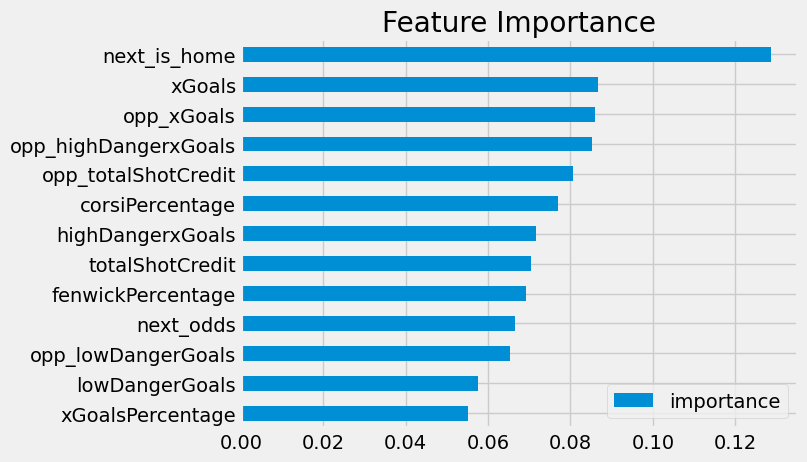

In [7]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# forecast on test

C:\Users\Michael Beebe\AppData\Local\Temp\ipykernel_14324\2878592154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


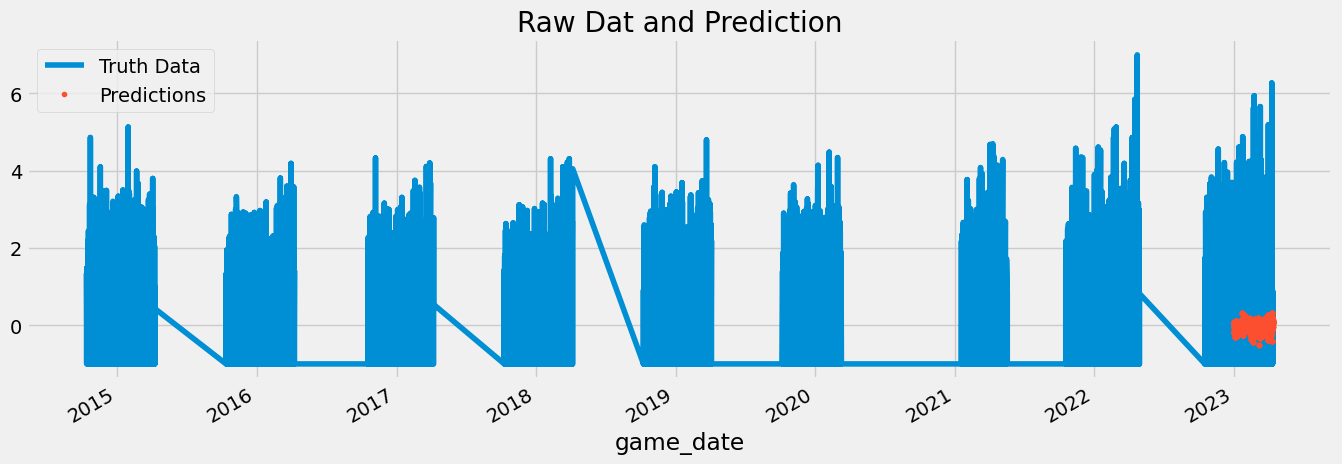

In [8]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[[TARGET]].plot(style='.', figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

## SCORE (RMSE)

In [10]:
score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.29


## CALCULATE ERROR
(look at worst and best prediction events)

In [68]:
test['error'] = test[TARGET] - test['prediction']
test['date'] = test.index.date
test.groupby(['date', 'game_id'])['error'].mean().sort_values(ascending=True).head(10)

date        game_id         
2023-02-23  2023-02-23WSHANA    4.071482
2023-01-24  2023-01-24ARIANA    3.570862
2023-03-08  2023-03-08VANANA    3.378956
2023-04-10  2023-04-10CHIMIN    2.690266
2023-01-19  2023-01-19PHICHI    2.607354
2023-02-17  2023-02-17OTTCHI    2.476236
2023-02-21  2023-02-21CHIVGK    2.459873
2023-03-11  2023-03-11TBLCHI    2.436903
2023-02-11  2023-02-11STLARI    2.391780
2023-03-02  2023-03-02VANMIN    2.359953
Name: error, dtype: float64

In [63]:
#test['error'].mean()
#test['prediction'].mean()
#test[TARGET].mean()
test.groupby(['date', 'game_id'])['error'].mean().sort_values(ascending=False).head(10)

date        game_id         
2023-02-23  2023-02-23WSHANA    4.071482
2023-01-24  2023-01-24ARIANA    3.570862
2023-03-08  2023-03-08VANANA    3.378956
2023-04-10  2023-04-10CHIMIN    2.690266
2023-01-19  2023-01-19PHICHI    2.607354
2023-02-17  2023-02-17OTTCHI    2.476236
2023-02-21  2023-02-21CHIVGK    2.459873
2023-03-11  2023-03-11TBLCHI    2.436903
2023-02-11  2023-02-11STLARI    2.391780
2023-03-02  2023-03-02VANMIN    2.359953
Name: error, dtype: float64

In [65]:
test['error'].sort_values(ascending=False).head(20)

game_date
2023-04-10    6.402075
2023-02-23    6.200011
2023-02-21    5.903984
2023-03-11    5.878151
2023-04-01    5.568824
2023-03-08    5.109712
2023-01-24    4.995151
2023-01-24    4.866679
2023-01-14    4.747347
2023-02-18    4.416783
2023-03-13    4.264479
2023-02-10    4.240661
2023-01-08    4.188174
2023-02-21    4.078993
2023-02-17    4.018204
2023-03-26    3.877205
2023-02-15    3.654665
2023-02-11    3.563571
2023-02-16    3.521468
2023-03-18    3.436082
Name: error, dtype: float64

In [72]:
df_corr = test.select_dtypes(include=np.number).corr()

In [74]:
#df_corr['next_profit'].sort_values(ascending=True).head(20)
df_corr.mean().sort_values(ascending=True).head(20)

penalties               -0.043559
opp_penalties           -0.037590
opp_penalties_4         -0.037216
penalties_4             -0.033733
penalityMinutes         -0.029358
opp_penalityMinutes     -0.025691
opp_odds_4              -0.022885
opp_penalityMinutes_4   -0.022660
penalityMinutes_4       -0.019873
ot_odds_4               -0.014947
opp_odds                -0.008420
opp_lowDangerGoals_4    -0.006407
prediction              -0.005345
next_is_home            -0.000241
ot_odds                  0.001958
reg_win                  0.005308
opp_lowDangerGoals       0.006576
next_odds                0.007671
is_home                  0.008764
reg_win_4                0.010852
dtype: float64

In [47]:
df_corr.to_csv(CSV_DB_PATH
                    + f"MODELS/CORR_PROFIT_{situation}_{season}.csv",
                    header=True,
                    index=False,
                )